# Task 1: Compare 'from-scratch' model with randomised weights vs pretrained model with pretrained weights
### Chosen model: **ResNet18**
### Chosen dataset: **CIFAR-10**

## Load all necessary modules

In [1]:
!pip install matplotlib numpy skorch torch torchvision

     |████████████████████████████████| 155 kB 4.0 MB/s 


In [2]:
#get list of environment variables
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
#Import all needed libraries
import torch
import torch.nn as nn
import torchvision.transforms as tt
import torch.optim
import random
from torch.utils.data import DataLoader

from PIL import Image
from torchvision.datasets import CIFAR10 

from skorch.classifier import NeuralNetClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from skorch import NeuralNetClassifier

import numpy as np
import matplotlib.pyplot as plt

from collections import OrderedDict


In [4]:
#CUDA device definition
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
#create reproducable results in skorch
def seed_torch(seed):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

seed_torch(seed=1)

## Helper fuctions

### Graph functions

In [6]:
#produces a training graph based off a Skorch NeuralNet Classifier
def drawTrainingGraph(net, title=None):
  plt.plot(net.history[:,'train_loss'], label="training loss")
  plt.plot(net.history[:,'valid_loss'],  label="validation loss")
  plt.plot(net.history[:,'valid_acc'], label="validation accurracy")
  plt.xlabel('Epoch')
  plt.grid()
  plt.legend()
  if title != None:
    plt.title(title)
  plt.show()  

In [7]:
#draws a bar chart
def drawBarChart(barNames, barValues, xAxisLabel, yAxisLabel, title):
  model_summary_fig = plt.figure()
  ax = model_summary_fig.add_axes([0,0,1,1])
  ax.bar(barNames, barValues)

  plt.xlabel(xAxisLabel)
  plt.ylabel(yAxisLabel)
  plt.title(title)

###Model Functions

In [8]:
#declares and fits a Skorch Classifier, returning the trained Classifier
def trainModel(model, 
               training_data, 
               training_labels, 
               max_epochs, 
               lr,
               optimizer,
               criterion
               ):
  modelClassifier = NeuralNetClassifier(
      model,
      max_epochs=max_epochs,
      lr=lr,
      optimizer=optimizer,
      batch_size=128,
      criterion=criterion,
      device = device
    )
  
  modelClassifier.fit(training_data, training_labels)
  return modelClassifier


In [9]:
#determines the prediction accuracy of a model on test data
def testModel(model, test_data, test_labels):
  predictions = model.predict(test_data)
  return accuracy_score(test_labels, predictions)

In [10]:
#Initialise a new output layer
def create_output_layer(input_num_features, output_num_features):
  out_layer = nn.Linear(input_num_features, output_num_features)
  out_layer == nn.init.normal_(out_layer.weight, std = 0.01)
  return out_layer

#adds a new output layer to a model
def add_output_layer(model, input_num_features, output_num_features):
  out = create_output_layer(input_num_features, output_num_features)
  return nn.Sequential(
      model,
      out
  )

### Data extraction functions

In [11]:
#extracts data from PyTorch built-in datasets into a numpy array
#any transforms declared on the datasort will be applied
def dataSetExtract(dataset, num_entries):
  data = np.empty(shape=(num_entries, 3, 224, 224), dtype=np.float32)
  labels = np.empty(shape=(num_entries), dtype=np.longlong)
  for x in range(0, num_entries):
    data[x] = dataset[x][0]
    labels[x] = dataset[x][1]  
  return data, labels

##Downloading datasets

In [12]:
#Transforms CIFAR-10 images so that they can be used by the NN models
cifar10_transform = tt.Compose([
                            tt.Resize(224), ## resize to 224 x 224
                            tt.ToTensor(), ## convert to tensor
                            tt.Normalize(mean=[0.485, 0.456,0.406], std=[0.229,0.225,0.225])
])
                                         
cifar10_train = CIFAR10(download=True,root="./data",train=True,transform=cifar10_transform)
cifar10_test = CIFAR10(root="./data",train=False,transform=cifar10_transform)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [13]:
cifar10_train[0][0].shape

torch.Size([3, 224, 224])

## Extract the data from the data sets

In [14]:
## Due to slow performances when using Fashion MNIST entries, I set these entries.
## If this crashes due to high-RAM usage, lower the numbers.
cifar10_num_entries = 6000
cifar10_num_test_entries = 2000

cifar10_training_data, cifar10_training_labels = dataSetExtract(cifar10_train, cifar10_num_entries)
cifar10_testing_data, cifar10_testing_labels = dataSetExtract(cifar10_test, cifar10_num_test_entries)


##Download Models

In [15]:
import torchvision.models as models
#pretrained model used for fine tuning
## adjust from 1000 classes to 10
trained_resnet18_model = add_output_layer(
                models.resnet18(pretrained=True),  
                1000,
                10,
              )

#model training from scratch
## adjust from 1000 classes to 10
untrained_resnet18_model = add_output_layer(
                models.resnet18(),    
                1000,
                10,
              )

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

## Finding the optimal hyperparameters for the pretrained ResNet18 model

In [16]:
#To find the hyperparameters, set to True
#This potentially takes over an hour to complete
find_best_hyper_parameters = False

In [17]:
#each epoch takes roughly 10 seconds with 6000 entries
#hence 20(epochs) * 3 (lrs) * 2 (optims) * 2 (lossfns) * 10 (classes) = 3600 seconds to run completely

epochs={
    "small-epoch":6,
    "mid-epoch":10,
    "big-epoch":14
}
lrs={
     "small-lr":0.001, 
     "mid-lr":0.01, 
     "big-lr":0.1
}
    
optimizers={
            "Adam":torch.optim.Adam,
            "SGD":torch.optim.SGD
}
    
lossfns={
          "CEL": nn.CrossEntropyLoss,
          "NLL":nn.NLLLoss,
}

model_name_list = list()
model_accuracy_list = list()
if find_best_hyper_parameters:
  for epoch_key, epoch_value in epochs.items():
    for lrs_key, lrs_value in lrs.items():
      for optimizers_key, optimizers_value in optimizers.items():
        for lossfns_key, lossfns_value in lossfns.items():
            model_name = "|".join([epoch_key ,lrs_key, optimizers_key, lossfns_key])
            print(model_name)
            res_net_temp_model = trainModel( 
              add_output_layer(
                models.resnet18(pretrained=True), ##new model each time   
                1000,
                10,
              ),
              cifar10_training_data,
              cifar10_training_labels,
              max_epochs=epoch_value,  ##different epocs
              lr=lrs_value, ##different learning rates
              optimizer=optimizers_value, #different optimizers
              criterion=lossfns_value # different lossfns
            )
            accuracy = testModel(res_net_temp_model, cifar10_testing_data, cifar10_testing_labels)
            model_name_list.append(model_name)
            model_accuracy_list.append(accuracy)
else:
  #list of names generated by past runs of this cell with find_best_hyper_parameter set to True
  model_name_list = ['small-epoch|small-lr|Adam|CEL',
    'small-epoch|small-lr|Adam|NLL',
    'small-epoch|small-lr|SGD|CEL',
    'small-epoch|small-lr|SGD|NLL',
    'small-epoch|mid-lr|Adam|CEL',
    'small-epoch|mid-lr|Adam|NLL',
    'small-epoch|mid-lr|SGD|CEL',
    'small-epoch|mid-lr|SGD|NLL',
    'small-epoch|big-lr|Adam|CEL',
    'small-epoch|big-lr|Adam|NLL',
    'small-epoch|big-lr|SGD|CEL',
    'small-epoch|big-lr|SGD|NLL',
    'mid-epoch|small-lr|Adam|CEL',
    'mid-epoch|small-lr|Adam|NLL',
    'mid-epoch|small-lr|SGD|CEL',
    'mid-epoch|small-lr|SGD|NLL',
    'mid-epoch|mid-lr|Adam|CEL',
    'mid-epoch|mid-lr|Adam|NLL',
    'mid-epoch|mid-lr|SGD|CEL',
    'mid-epoch|mid-lr|SGD|NLL',
    'mid-epoch|big-lr|Adam|CEL',
    'mid-epoch|big-lr|Adam|NLL',
    'mid-epoch|big-lr|SGD|CEL',
    'mid-epoch|big-lr|SGD|NLL',
    'big-epoch|small-lr|Adam|CEL',
    'big-epoch|small-lr|Adam|NLL',
    'big-epoch|small-lr|SGD|CEL',
    'big-epoch|small-lr|SGD|NLL',
    'big-epoch|mid-lr|Adam|CEL',
    'big-epoch|mid-lr|Adam|NLL',
    'big-epoch|mid-lr|SGD|CEL',
    'big-epoch|mid-lr|SGD|NLL',
    'big-epoch|big-lr|Adam|CEL',
    'big-epoch|big-lr|Adam|NLL',
    'big-epoch|big-lr|SGD|CEL',
    'big-epoch|big-lr|SGD|NLL'
 ]

#list of test data predictions, generated from past runs of this cell with find_best_hyper_parameter set to True
model_accuracy_list =[0.7785,
 0.1765,
 0.7795,
 0.169,
 0.23,
 0.0965,
 0.87,
 0.2235,
 0.098,
 0.129,
 0.3385,
 0.1115,
 0.712,
 0.099,
 0.818,
 0.2505,
 0.215,
 0.0975,
 0.881,
 0.113,
 0.093,
 0.1465,
 0.328,
 0.1175,
 0.782,
 0.1405,
 0.8405,
 0.3535,
 0.309,
 0.0925,
 0.8775,
 0.095,
 0.119,
 0.0995,
 0.523,
 0.0967
 ]



            

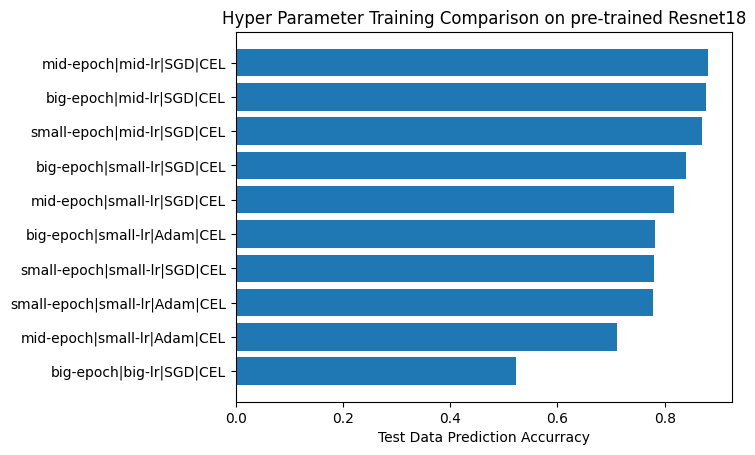

In [18]:
##create tuples for each test result with each hyperparameter combinations
training_tuple_list = list()
for ii in range(0, len(model_name_list)):
  mTuple = (model_name_list[ii], model_accuracy_list[ii])
  training_tuple_list.append(mTuple)
## sort the tuples by the greatest prediction accuracy
training_tuple_list.sort(key=lambda tup: tup[1], reverse=True)
## get the top ten best results
top_ten = training_tuple_list[:10]

top_ten_names =[tup[0] for tup in top_ten]
top_ten_predictions =[tup[1] for tup in top_ten]
#drawBarChart(top_ten_names, top_ten_predictions, "hyper parameter setups", "prediction accurracy", "top ten hyper parameter setups")


##draw graph of the top ten hyper parameter combinations
plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = np.arange(10)
ax.barh(y_pos, top_ten_predictions, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(top_ten_names)
ax.invert_yaxis()
ax.set_xlabel('Test Data Prediction Accurracy') 
ax.set_title("Hyper Parameter Training Comparison on pre-trained Resnet18")
plt.show()


In [19]:
best_combination = top_ten_names[0]
print("best performing hyperparameters = " + best_combination)

#acquire the hyperparameters from best combination
epoch_str, lr_str, opt_str, ls_fn_str = best_combination.split("|")

best_lr = lrs[lr_str]
best_epoch = epochs[epoch_str]
best_optimizer = optimizers[opt_str]
best_loss_fn = lossfns[ls_fn_str] 

best performing hyperparameters = mid-epoch|mid-lr|SGD|CEL


##Trained ResNet18 Model

###Train the model

In [ ]:
# training the pretrained ResNet18 model
trainedResNet = trainModel( 
    trained_resnet18_model, 
    cifar10_training_data,
    cifar10_training_labels,
    max_epochs=best_epoch, 
    lr=best_lr,
    optimizer=best_optimizer,
    criterion=best_loss_fn
)


  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.9391       0.7675        0.6372  14.3552
      2        0.3762       0.8350        0.4387  13.5458


## Train the model from scratch with randomly initialized weights

The previous model now has randomly initialized weights.

In accordance to the Pytorch webpage:https://pytorch.org/vision/stable/models.html,[link text](https://) "You can construct a model with random weights by calling its constructor:"


### Training the model

In [ ]:
# training the model with randomly initialized weights 
untrainedResNet = trainModel(
    untrained_resnet18_model, 
    cifar10_training_data,
    cifar10_training_labels,
    max_epochs=best_epoch, 
    lr=best_lr,
    optimizer=best_optimizer,
    criterion=best_loss_fn
)

## Plot the models' training process

In [ ]:
#plotting the graphs
drawTrainingGraph(trainedResNet, title="Pretrained Resnet18")
drawTrainingGraph(untrainedResNet, title="Resnet18 with randomised weights")

## Models performance on test data

In [ ]:
#testing both models against each other
pre_trained_model_results = testModel(trainedResNet, cifar10_testing_data, cifar10_testing_labels)
untrained_model_results = testModel(untrainedResNet, cifar10_testing_data, cifar10_testing_labels)

In [ ]:
#display the results from the pretrained and random-weighted ResNet18 models
model_names_1 = ["Pretrained Resnet18 model", "Resnet18 model with randomised weights"]
model_results_1 = [pre_trained_model_results, untrained_model_results]
drawBarChart(model_names_1, model_results_1, "Models", "Prediction Percentage", "Model Comparison")
for x in range(0, len(model_results_1)):
  print(model_names_1[x] + " predicts: " + str(model_results_1[x] * 100) + "%" )

## Comparing the models

From the the training graphs and the testing data, the pretrained model outperforms the untrained model as it has:

1.   A better validation accurracy
2.   A much lower validation loss
3.   A much higher prediction accuracy on test data

# Task 2 Comparing the performance of different pretrained models
The best model from task 1 was the pretrained ResNet18 model.

##Cleaning up previous model and classifier

In [ ]:
#clear the memory of the previous ResNet18 models by deleting objects that are no longer required
import gc
del untrained_model_results
del untrainedResNet
del untrained_resnet18_model

gc.collect()
torch.cuda.empty_cache()

##Define other pretrained models
### Chosen models: **Resnet18, SqueezeNet and Shuffle Net**

In [ ]:
#SqueezeNet
model_1 = models.squeezenet1_1 (pretrained=True)
#change the final conv2d layer of SqueezeNet so that it outputs 10 classes
model_1.classifier[1] = nn.Conv2d(512, 10, kernel_size=(1, 1), stride=(1, 1))
#add an additional layer to shufflenet so that it outputs 10 classes
model_2 = add_output_layer(
              models.shufflenet_v2_x1_0 (pretrained=True),
              1000,
              10
            ) 
model_name_1 = "Squeezenet1_1"
model_name_2 = "Shuffle Net"


##Train the pretrained models

In [ ]:
##train SqueezeNet
print(model_name_1)
model_classifier_1 = trainModel(
    model_1, 
    cifar10_training_data, 
    cifar10_training_labels,
    max_epochs=best_epoch, 
    lr=best_lr,
    optimizer=best_optimizer,
    criterion=best_loss_fn
)

In [ ]:
# train Shuffle Net
print(model_name_2)
model_classifier_2 = trainModel(
    model_2, 
    cifar10_training_data, 
    cifar10_training_labels,
    max_epochs=best_epoch, 
    lr=best_lr,
    optimizer=best_optimizer,
    criterion=best_loss_fn
)


## Plot the training

In [ ]:
#display the training graphs of each model
drawTrainingGraph(trainedResNet, title="ResNet18-Pre-Trained")
drawTrainingGraph(model_classifier_1, title=model_name_1)
drawTrainingGraph(model_classifier_2, title=model_name_2)

## Test the models performance on test data

In [ ]:
#create an array of prediction accuracies, one for each model.
multi_test_results = [
                      pre_trained_model_results,
                      testModel(model_classifier_1, cifar10_testing_data, cifar10_testing_labels),
                      testModel(model_classifier_2, cifar10_testing_data, cifar10_testing_labels),
]

In [ ]:
#compare the prediction accuracies of the pretrained models
all_model_names = ["Pre trained Resnet18", model_name_1, model_name_2]
drawBarChart(all_model_names, multi_test_results, "Models", "Prediction Percent", "Model Comparison")
for x in range(0, len(multi_test_results)):
  print(all_model_names[x] + " predicts: " + str(multi_test_results[x] * 100) + "%" )

## Summary

The best performing model was the pretrained ResNet18 model as it produced the highest prediction percentage on the test data.

The hyperparameters were tuned to best suit the pretrained ResNet18 model which likely gave it an edge over the other models.

#Task 3: Investigate the learnt CNN features from the last convolution layer and one intermediate layer.
The best model from task 2 was: **ResNet18**

## Cleaning up previous models and classifiers

In [ ]:
#clear memory of objects that are no longer required
del model_1
del model_classifier_1
del model_2
del model_classifier_2
gc.collect()
torch.cuda.empty_cache()

## Extract the features from the last CNN layer and an intermediate layer

All the layers in ResNet18 are shown below:

In [ ]:
#display the modules of the model
trained_resnet18_model._modules

The last convolution layer is 'avgpool'

The intermediate layer I chose is 'layer2'

## Extract training features

In [ ]:
#define layers to be extracted
intermediate_layer_name = 'conv2'
final_conv_layer_name = 'avgpool'

extracted_features = {
    intermediate_layer_name:[],
    final_conv_layer_name:[]
}

#produce a hook function that adds a 'features' output to be added to the previously defined 'extracted_features' array
def get_activation(layer_name):
    def hook(model, input, output):
        extracted_features[layer_name].append(output.detach().cpu().numpy())
    return hook

##As the ResNet18 model is wrapped in an nn.sequential, we have to retrieve the first item to get the model
resnet_modules = trained_resnet18_model._modules.get("0")

#retrieve intermediate CNN layer 
intermediate_conv_layer = resnet_modules._modules.get("layer1")[1]._modules.get("conv2")
intermediate_conv_layer._forward_hooks = OrderedDict()
intermediate_conv_layer.register_forward_hook(get_activation(intermediate_layer_name))

#retrieve final cnn layer after average pooling
final_conv_layer = resnet_modules._modules.get(final_conv_layer_name)
final_conv_layer._forward_hooks = OrderedDict()
final_conv_layer.register_forward_hook(get_activation(final_conv_layer_name))

In [ ]:
#run each set of training data through the model, so that the hook function can be called and the data will be added to the 'extracted_features' dictionary
trained_resnet18_model.to(device)
for data in cifar10_training_data:
  testd = torch.from_numpy(data).to(device)
  testd = testd.unsqueeze(0).to(device)
  trained_resnet18_model(testd)
  


In [ ]:
##create numpy arrays of each layer's features
training_final_layer_features = np.concatenate(extracted_features[final_conv_layer_name], axis=0)
training_intermediate_layer_features = np.asarray(extracted_features[intermediate_layer_name], np.float32)

In [ ]:
print("intermediate layer shape:" + str(training_intermediate_layer_features[0].shape))
print("final convolution layer shape:" + str(training_final_layer_features[0].shape))
print("length of intermediate layer features: " + str(len(training_intermediate_layer_features)))
print("length of final convolution layer features: " + str(len(training_final_layer_features)) )

Extract testing features

In [ ]:
extracted_features = {
    intermediate_layer_name:[],
    final_conv_layer_name:[]
}
#run each set of testing data through the model, so that the hook function can be called and the data will be added to the "extracted_features" dictionary
for data in cifar10_testing_data:
  testd = torch.from_numpy(data).to(device)
  testd = testd.unsqueeze(0).to(device)
  trained_resnet18_model(testd)

In [ ]:
##create numpy arrays of each layer's features
testing_final_layer_features = np.concatenate(extracted_features[final_conv_layer_name], axis=0)
testing_intermediate_layer_features = np.asarray(extracted_features[intermediate_layer_name], np.float32)

In [ ]:
print("final convolution layer shape:" + str(testing_final_layer_features[0].shape))
print("intermediate layer shape:" + str(testing_intermediate_layer_features[0].shape))
print("length of intermediate layer features: " + str(len(testing_final_layer_features)))
print("length of final convolution layer features: " + str(len(testing_intermediate_layer_features)) )

In [ ]:
#create average pool to transform the extracted intermediate layer features' dimensions to match the number of channels in the extracted final layer features
avgp = nn.AvgPool2d((8,24), stride=(16,32))
def avgPoolFeature(feature, avgp = avgp):
  return avgp(torch.from_numpy(feature[0])).numpy()

def avgPoolFeatureArray(features, avgp = avgp):
  return np.asarray([avgPoolFeature(feature) for feature in features], np.float32)

training_intermediate_layer_features = avgPoolFeatureArray(training_intermediate_layer_features)
testing_intermediate_layer_features =  avgPoolFeatureArray(testing_intermediate_layer_features)

In [ ]:
training_intermediate_layer_features[0].shape

##Softmax Regression Models

In [ ]:
#define softmax regression model
class SoftMaxRegression(nn.Module):
  #the linear layers input can be defined by the feature_length parameter
  def __init__(self, feature_length):
    super(SoftMaxRegression, self).__init__()
    linear_layer = nn.Linear(feature_length, 10)
    nn.init.normal_(linear_layer.weight, std=0.01)
    #flatten any input
    self.seq = nn.Sequential(nn.Flatten(), linear_layer)
  def forward(self, feature):
    return nn.functional.softmax(self.seq(feature), dim=-1)


In [ ]:
length_of_final_layer_feature = np.prod(training_final_layer_features[0].shape)
length_of_intermediate_layer_feature = np.prod(training_intermediate_layer_features[0].shape)
length_of_cifar_input = np.prod(cifar10_training_data[0].shape)
print("length of flattened final layer feature: " + str(length_of_final_layer_feature))
print("length of intermediate layer feature: " + str(length_of_intermediate_layer_feature))
print("length of cifar input: " + str(length_of_cifar_input))

In [ ]:
#create and train a softmax regression model using the extracted final layer features
final_layer_soft_max_model = SoftMaxRegression(length_of_final_layer_feature)

final_layer_soft_max_classifier = trainModel(
    final_layer_soft_max_model, 
    training_final_layer_features, 
    cifar10_training_labels,
    max_epochs=best_epoch, 
    lr=best_lr,
    optimizer=best_optimizer,
    criterion=nn.CrossEntropyLoss
)

In [ ]:
#create and train a softmax model using the extracted intermediate layer features
intermediate_layer_soft_max_model = SoftMaxRegression(length_of_intermediate_layer_feature)
intermediate_layer_soft_max_classifier = trainModel(
    intermediate_layer_soft_max_model,
    training_intermediate_layer_features, 
    cifar10_training_labels,
    max_epochs=best_epoch, 
    lr=best_lr,
    optimizer=best_optimizer,
    criterion=nn.CrossEntropyLoss
)

In [ ]:
#create and train a softmax model using the orignal cifar10 data
orginal_input_soft_max_model = SoftMaxRegression(length_of_cifar_input)
orginal_input_soft_max_model_classifier = trainModel(
    orginal_input_soft_max_model,
    cifar10_training_data, 
    cifar10_training_labels,
    max_epochs=best_epoch, 
    lr=best_lr,
    optimizer=best_optimizer,
    criterion=nn.CrossEntropyLoss
)

##Test Softmax Regression Models

In [ ]:
#test each softmax model
soft_max_results = [
  testModel(final_layer_soft_max_classifier, testing_final_layer_features, cifar10_testing_labels),
  testModel(intermediate_layer_soft_max_classifier, testing_intermediate_layer_features, cifar10_testing_labels),
  testModel(orginal_input_soft_max_model_classifier, cifar10_testing_data, cifar10_testing_labels)

]
#show the results
print(soft_max_results)
drawBarChart(["Final convolution layer", "Intermediate layer", "Original input"], soft_max_results, "Layers", "Prediction Percentage", "SoftMax Comparison")

## Summary for task 3

The Softmax Regression models performed better when trained on features from the last convolutional layer. It can be concluded that the features from the last convolutional layer provide information that is better suited to finding the correct label. This constrast with the performance of similar models trained on feature from an intermediate layer, which was significantly lower.

These results can be viewed on the comparison bar chart.


# Save the Pre-trained Resnet18 Model

In [ ]:
#mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
#save the model to Google Drive
model_save_name = "PretrainedResnet18-19614652.pt"
path = F"/content/gdrive/MyDrive/{model_save_name}" 
torch.save(trained_resnet18_model.state_dict(), path)